In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.modules.loss import MSELoss
from torch.utils.data import dataloader
import utils
from arguments import parse_args
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import wandb
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import os
from sampling import DelaunayTriangulationBlur
from PIL import Image
import random
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import numba as nb
from torchvision.transforms import ToTensor, ToPILImage

from IPython.display import clear_output as clear

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# export OMP_NUM_THREADS=1
# ALG='SwinIR'
# LOGDIR='logs/swinir_denoise_64_20000'
# PNUM=20000
# GROUP='SwinIR_denoise_64_20000'

# # change num point
# CUDA_VISIBLE_DEVICES=4,5,6 python train.py --alg $ALG \
#                 --log_dir $LOGDIR \
#                 --point_num $PNUM \
#                 --batch_size 4 \
#                 --img_width 64 \
#                 --img_height 64 \
#                 --img_size 64 \
#                 --scale 1 \
#                 --seed 0 \
#                 --epoch 200 \
#                 --wandb \
#                 --wandb_project CG \
#                 --wandb_name 0 \
#                 --wandb_group $GROUP \
    
# args = parser.parse_args(args=['--device', '0',  '--no_cuda'])

args = parse_args( [ "--alg", "VDSR"
                   , "--description", "vdsr-1e-3"
                   , "--lr", "1e-3"
                   , "--epoch", "20"
                   , '--data_root', 'data/celeba'
                   , '--batch_size', '1'
                   , '--point_num', '1000'
                   , '--method', 'center'
                   , '--img_width', '256'
                   , '--img_height', '256'
                   , '--img_size', '256'
                   ])

In [4]:
from sampling.triangulation_blur import DelaunayTriangulationBlur_4Channel
class TrainDataset_4Channel(Dataset):
    def __init__(self, args):
        self.args = args
        self.root_path = os.path.join(args.data_root, 'train')
        self.img_list = os.listdir(self.root_path)
        try:
            self.img_list.remove('.DS_Store')
        except:
            pass
        self.method = args.method
        self.transform_on_hr = self.get_transform('hr')
        self.transform_on_lr = self.get_transform('lr')

    
    def get_transform(self, target):
        if target=='lr':
            trans = transforms.Compose( 
                [transforms.Resize((self.args.img_width,self.args.img_height))]
                # [transforms.CenterCrop((self.args.img_width,self.args.img_height))]
                )
        elif target=='hr':
            trans = transforms.Compose( 
                [transforms.Resize((self.args.img_width,self.args.img_height))]
                # [transforms.CenterCrop((self.args.img_width,self.args.img_height))]
                )
        else:
            raise Exception('Transform not supported.')
        return trans

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, self.img_list[idx])
        img_pair = dict()

        img_hr = Image.open(img_path)
        img_lr = self.transform_on_lr(img_hr)
        
        img_hr= np.array(self.transform_on_hr(img_hr))
        img_pair['hr'] = torch.tensor(img_hr, dtype=torch.float32)

        img_lr = DelaunayTriangulationBlur_4Channel(np.array(img_lr), \
            self.args.point_num, self.args.method, sample_point_method='random')
        img_pair['lr'] = torch.tensor(np.array(img_lr), dtype=torch.float32)
        
        img_pair['hr'] /= 255
        # img_pair['lr'] /= 255 # Moved to DelaunayTriangulationBlur_4Channel

        return img_pair
    
    def __len__(self):
        return len(self.img_list)
    
train_dataset = TrainDataset_4Channel(args)
train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=True,
                                collate_fn=utils.collect_function,)

In [5]:
device = torch.device('cuda:0' if args.device == 'gpu' and torch.cuda.is_available() else 'cpu')

model = utils.make_model(args).to(device)
model = model.float()

optimizer = optim.Adam(params=model.parameters(),lr=args.lr)
optimizer.zero_grad()

In [6]:
wandb.init(project="VDSR-1000pts-center", entity="purewhite2019")
wandb.config = {
  "args" : args,
  "seed" : 31415926
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: purewhite2019 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
epoch: 19 | iter: 399/400 | loss: -0.7931110858917236: 100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


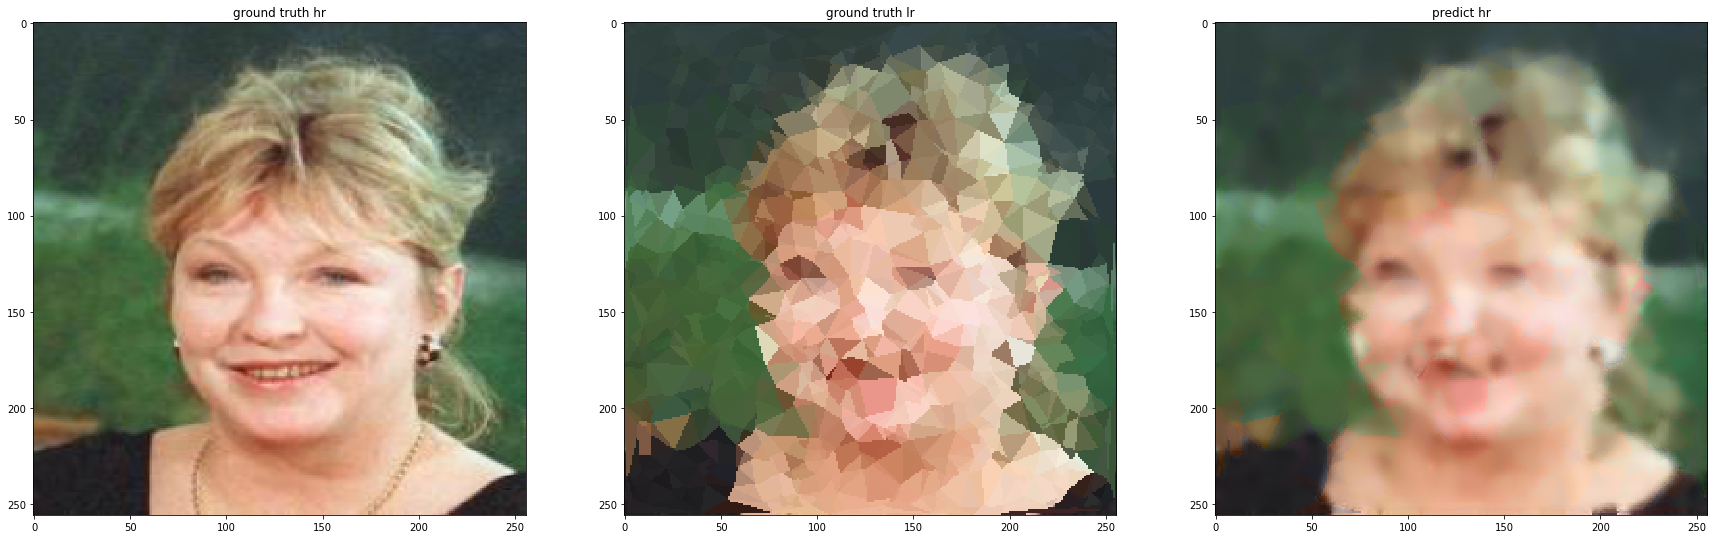

In [7]:
wandb.watch(model)
model.train()
for e in range(args.epoch):
    idx = random.randint(0, len(train_dataset)-1)
    img_pair = utils.collect_function([train_dataset[idx]])

    img_lr = img_pair['lr'].permute(0, 2, 3, 1)[:, :, :, :-1]
    img_hr = img_pair['hr'].permute(0, 2, 3, 1)
    
    clear()
    model.eval()
    with torch.no_grad():
        output = model(img_lr.permute(0, 3, 1, 2).to(device))
        img_pred = output.permute(0, 2, 3, 1)

    utils.show_gt_and_pred(img_hr=img_hr[0].cpu().numpy(), img_lr=img_lr[0].cpu().numpy(), pred_hr=img_pred[0].cpu().numpy(), figsize=(30, 30))
    
    tot_mse = 0
    tot_psnr = 0
    tot_ssim = 0

    tot_lr_mse = 0
    tot_lr_psnr = 0
    tot_lr_ssim = 0
    
    model.train()
    loop = tqdm.tqdm(train_loader)
    for idx, img_pair in enumerate(loop):
        
        img_lr = img_pair['lr'].permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_hr = img_pair['hr'].to(device)
        output = model(img_lr)
        
        img_pred = output.to(device)

        mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_pred.reshape((img_hr.shape[0], -1)))
        psnr = utils.psnr(img_hr, img_pred)
        ssim = utils.ssim(img_hr, img_pred)
        loss = -psnr/300 - ssim + mse
        
        tot_mse += mse
        tot_psnr += psnr
        tot_ssim += ssim
        
        lr_psnr = utils.psnr(img_hr, img_lr)
        lr_ssim = utils.ssim(img_hr, img_lr)
        lr_mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_lr.reshape((img_hr.shape[0], -1)))
            
        tot_lr_mse += lr_mse
        tot_lr_psnr += lr_psnr
        tot_lr_ssim += lr_ssim
        
        loss = -psnr/300 - ssim + mse
            
        wandb.log({"psnr improvement": (psnr-lr_psnr)*100/lr_psnr})
        wandb.log({"ssim improvement": (ssim-lr_ssim)*100/lr_ssim})
        wandb.log({"mse improvement": (lr_mse-mse)*100/lr_mse})
        wandb.log({"psnr": psnr})
        wandb.log({"ssim": ssim})
        wandb.log({"mse": mse})
        wandb.log({"loss": loss})
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_description(f"epoch: {e} | iter: {idx}/{len(train_dataset)} | loss: {loss.item()}")
    
    e += 1
    utils.save_model(model, e, args)
    